In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset
import torch.nn.functional as F

import pandas as pd
from PIL import Image
import tqdm
from glob import glob

# Mingxing Tan, Quoc V. Le, EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ICML 2019
from efficientnet_pytorch import EfficientNet

In [2]:
class GTSRB(Dataset):
    def __init__(self):
        self.path = "./GTSRB/Training"
        self.folder_paths = sorted(glob("{}/*/".format(self.path)))
        self.class_ind = 0
        
        # data augmentation
        self.img_transforms = transforms.Compose([
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.imgs = []
        self.lbls = []
        
        for folder_path in self.folder_paths:
            image_paths = sorted(glob("{}/*".format(folder_path)))
            # remove last csv file in the folder
            image_paths.pop()
            self.imgs += image_paths
            self.lbls += [self.class_ind] * len(image_paths)
            self.class_ind += 1

    def __getitem__(self, index):
        img = Image.open(self.imgs[index]).convert("RGB")
        img = self.img_transforms(img)
        lbl = self.lbls[index]
        return img, lbl
    
    def __len__(self):
        return len(self.imgs)

In [3]:
class GTSRBTest(Dataset):
    def __init__(self):
        self.imgs = []
        self.lbls = []
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        for filename in sorted(glob("./GTSRB/Final_Test/Images/*.ppm")):
            img = Image.open(filename).convert("RGB")
            self.imgs.append(img)
        
        df = pd.read_csv("./GTSRB/Final_Test/GT-final_test.csv")
        self.lbls = list(df["ClassId"])
    
    def __getitem__(self, index):
        img = self.img_transforms(self.imgs[index])
        lbl = self.lbls[index]
        return img, lbl
    
    def __len__(self):
        return len(self.imgs)

In [16]:
train_set = GTSRB()
test_set = GTSRBTest()

train_size = int(len(train_set) * 0.8)
val_size = len(train_set) - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

print(len(train_set))
print(len(val_set))
print(len(test_set))

21312
5328
12630


In [5]:
torch.manual_seed(0)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

In [6]:
class EfficientNetWrapper(nn.Module):
    def __init__(self):
        super(EfficientNetWrapper, self).__init__()
        
        # Load imagenet pre-trained model 
        self.effNet = EfficientNet.from_pretrained('efficientnet-b0')
        self.MLP = nn.Sequential(
            nn.Linear(1000, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 43)
        )
        
#         self.fc1 = nn.Linear(1000, 500)
#         self.fc2 = nn.Linear(500, 200)
#         self.fc3 = nn.Linear(200, 43)
    
    
    def forward(self, x):
        x = self.effNet(x)
        x = self.MLP(x)
        
#         Mish activation function
#         x = self.fc1(x)
#         x = x * (torch.tanh(F.softplus(x)))
#         x = self.fc2(x)
#         x = x * (torch.tanh(F.softplus(x)))
#         x = self.fc3(x)
        return x

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("yes")
else:
    device = torch.device('cpu')
    
model = EfficientNetWrapper()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

yes
Loaded pretrained weights for efficientnet-b6


In [8]:
def evaluate_acc(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(dataloader):
            outs = model(imgs.to(device))
            _, temp_preds = torch.max(outs, 1)
            total += lbls.size(0)
            temp_preds = temp_preds.cpu()
            correct += (temp_preds == lbls).sum().item()
    return correct / total

In [9]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

NUM_EPOCHS=2
best_val_acc = 0

for epoch in tqdm.notebook.tqdm(range(NUM_EPOCHS)):
    model.train()
    correct = 0
    for i, (imgs, lbls) in enumerate(train_loader):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        train_loss = F.cross_entropy(output, lbls).to(device)
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(lbls.view_as(pred)).sum().item()
        train_acc = 100. * correct / len(train_loader.dataset)
        
        train_loss_history.append(train_loss.item())
        train_acc_history.append(train_acc)
        
    model.eval()
    val_loss = 0
    correct = 0
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        output = model(imgs)
        val_loss += F.cross_entropy(output, lbls).to(device).item() 
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(lbls.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100. * correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        
    

    lr_scheduler.step()

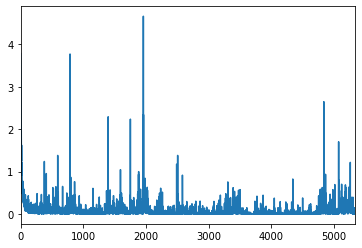

In [10]:
pd.Series(train_loss_history).plot()

In [11]:
test_accuracy = evaluate_acc(model, test_loader)
print(test_accuracy)

0.9699129057798892


In [12]:
# Adam ELU, 20 epoches, batchsize=100, efficientnet b3, 98.46
# Adam ReLU, 20 epoches, batchsize=100, 97.87
# 